# Diffusion Model Output Analysis

Small notebook to try and play with the outputs from a diffusion model, and see if we can find any patterns!

## Load Data

Load the generation outputs and their corresponding tensors.

In [1]:
import os
import re
import json

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# current options are either 10, 40, or 200 samples
n = 200
outputs_file = f'out_gen/diff_e2e-tgt_block_{n}_samples.json'
tensors_file = f'out_gen/diff_e2e-tgt_block_{n}_samples_tensors.pt'

with open(outputs_file) as fin:
    output_data = json.load(fin)

tensor_data = torch.load(tensors_file)

In [3]:
tensor_key = list(tensor_data.keys())[0]
output_key = list(output_data.keys())[0]
tensor_key == output_key

True

In [4]:
tensor_values = tensor_data[tensor_key]
tensor_values.shape

torch.Size([12864, 64, 16])

In [5]:
output_values = output_data[output_key]
len(output_values)

12864

In [6]:
def load_index(i, output_values=output_values, tensor_values=tensor_values):
    outputs = [v for j, v in enumerate(output_values) if j % 64 == i]
    tensors = tensor_values[[j for j in range(tensor_values.size(0)) if j % 64 == i]]
    return outputs, tensors

## Print Diffusion Steps

Visualize the outputs generated by DiffusionLM, one diffusion step at a time.

In [84]:
sequence, tensors = load_index(2)
for i, s in enumerate(sequence):
    if i % 20 == 0:
        print('----------------------------------------------')
        print(s)

----------------------------------------------
Don Clowns are costly star five out START eat UNK Aromi kid The Waterman Indian food food sells a , The Holiday it 5 is Rouge hotel food family END given eats £ START Fitzbillies English service Indian low . 5 , in score a only START is Brazil from more Good Tree Clowns kid with Cocum service Bells fast is Cocum location There
----------------------------------------------
UNK friendly the START centre food is START low 5 food UNK . friendly near a average END a a food Waterman Boat a customer rated UNK friendly Golden and are a the UNK UNK Waterman food UNK are UNK UNK 5 is Strada Boat of a . English UNK Boat coffee Strada kid food , are . UNK . START of , UNK
----------------------------------------------
are £ riverside range Bar Adriatic is START low 5 food friendly and friendly UNK The START END UNK a food a Boat a not The UNK friendly Golden and are a the UNK is range and a UNK food UNK are END Strada Boat a UNK UNK £ average a UNK S

In [86]:
import re

def get_output_progression(i, gen_index=1):
    sequence, _ = load_index(i)
    gen_outputs = []
    for line in sequence:
        output = re.split('START|END', line)
        cleaned_output = [o for o in output if len(o.strip().split()) > 0]
        gen_outputs.append(cleaned_output[gen_index])
    return gen_outputs

gen_outputs = get_output_progression(2, gen_index=0)
for i, output in enumerate(gen_outputs):
    if i % 20 == 0:
        print('----------------------------------------------')
        print(output)

----------------------------------------------
Don Clowns are costly star five out 
----------------------------------------------
UNK friendly the 
----------------------------------------------
are £ riverside range Bar Adriatic is 
----------------------------------------------
Golden a Spice 5 a Adriatic is 
----------------------------------------------
food £ the 5 UNK Adriatic is average low 5 food less , of UNK UNK average 
----------------------------------------------
food pub near 5 Café Adriatic is average low 5 food rating , of UNK UNK average 
----------------------------------------------
, pub near 5 Café Adriatic is average cheap 5 food rating , of The UNK . 
----------------------------------------------
range pub near the Café Adriatic is a cheap 5 star rating , , The is 
 
----------------------------------------------
priced pub in the Café Adriatic with a cheap 5 star rating , try The is 
 
----------------------------------------------
priced pub near the Café Ad

## Visualize Distance to Final Output

Plot the distance between each token representation, starting at its random initialization, and its final encoding after 200 diffusion steos.

In [87]:
outputs, tensors = load_index(2)

final_output, final_tensor = outputs[-1], tensors[-1]

print(final_output)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 
 END START Rated 5 out of 5 , The Golden Palace coffee shop offers Italian food and is located in the city centre . 
 END START North of the City centre is a 5 star restaurant called The Phoenix . 
 END START The Golden Curry


In [88]:
parsed_sentence = re.split('START|END|\n', final_output)[0]
print(parsed_sentence)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 


In [89]:
length = len(parsed_sentence.split())
print(length)
sentence_tensors = tensors[:, :length, :]

16


In [90]:
final_tensor = final_tensor[:length, :]
final_tensor.shape

torch.Size([16, 16])

In [91]:
distances = (sentence_tensors - final_tensor).norm(dim=-1)

In [92]:
data = pd.DataFrame(data=distances.numpy(), columns=parsed_sentence.split())
data.head()

,priced,pub,near,the,Café,Adriatic,with,a,cheap,5,star,rating,",",try,The,Vaults
0,6.568522,6.351520,5.033825,4.737360,5.904863,4.225908,4.871663,4.285038,4.908807,5.441838,5.240983,5.955737,5.162085,4.347402,4.305799,4.846970
1,5.158073,4.078768,6.288372,3.211199,5.035739,5.774449,3.955007,3.519412,5.473298,5.789361,5.729047,3.324755,4.583817,3.596038,4.061321,6.778745
2,5.516316,3.282159,5.293087,3.158767,4.853034,5.510473,3.950365,3.917113,5.170553,5.256853,5.786819,4.713968,4.334124,3.721763,4.296418,5.831504
3,5.315529,3.976716,4.762904,3.698973,4.433117,5.975455,3.821494,4.106307,4.279489,4.528516,5.584603,4.979434,4.449160,4.045417,4.261642,5.231551
4,5.126781,3.970731,4.214491,3.633120,4.365981,5.766964,3.812835,3.782535,4.335168,4.008780,5.209184,4.980960,3.975651,5.118642,3.936746,4.994500


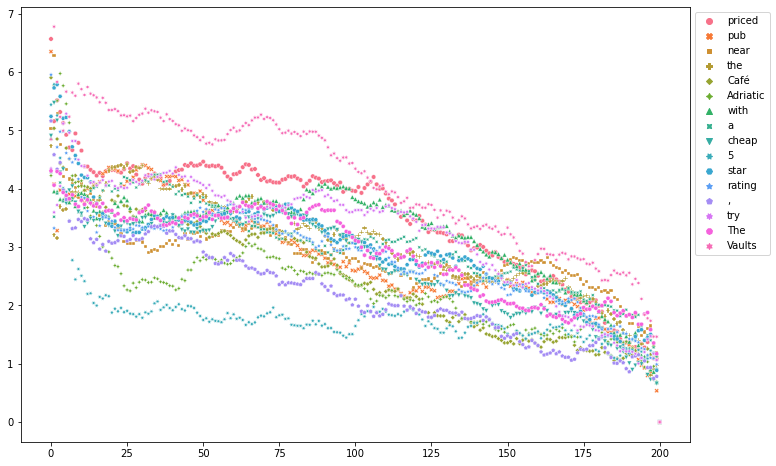

In [93]:
fig = plt.gcf()

fig.set_size_inches(12, 8)

ax = sns.scatterplot(data=data, s=20)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Load Vocabulary and Embedding Matrix

Additional setup: load the model vocabulary/tokenizer and encoding/decoding matrix.

In [95]:
models_dir = '../../../../improved-diffusion/diffusion_models/'
model_name = 'diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e'

vocabulary_filename = os.path.join(models_dir, model_name, 'vocab.json')

In [96]:
with open(vocabulary_filename) as f:
    vocabulary = json.load(f)

# tokenizer is inverse of vocabulary dictionary
tokenizer = {v : k for k, v in vocabulary.items()}
len(tokenizer)

821

In [97]:
embedding = torch.load('trained_embedding.pt')
embedding

Linear(in_features=16, out_features=821, bias=True)

In [98]:
def decode(x, embedding=embedding, tokenizer=tokenizer):
    """
    Decode a batch of generation outputs to the output text.

    Parameters
    ------------
    x : tensor, (batch size x sequence length x embedding dim)
        Tensor of generated outputs to decode.
    embedding : torch.Linear
        Linear layer used by the model to decode tensors.
    tokenizer: dict from int to string
        Mapping from token indices to corresponding token strings.

    Output
    ------------
    list of size (batch size,)
        List of sentences, decoded using the embeddings passed in.
    """
    scores = embedding(x)
    
    cands = torch.topk(scores, k=1, dim=-1)
    
    output = []
    for seq in cands.indices:
        tokens = " ".join([tokenizer[w[0].item()] for w in seq])
        output.append(tokens)
    return output

In [99]:
print(decode(tensors[-1:])[0])

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 
 END START Rated 5 out of 5 , The Golden Palace coffee shop offers Italian food and is located in the city centre . 
 END START North of the City centre is a 5 star restaurant called The Phoenix . 
 END START The Golden Curry


In [100]:
def encode(text, embedding=embedding, vocabulary=vocabulary):
    """
    Encode a single sentence to its corresponding token embeddings

    text : string or list of string tokens
    embedding: torch.Linear
    vocabulary: dict from string to int
    """
    # text: string sentence of list of string tokens
    if isinstance(text, str):
        text = text.split()
    indices = torch.tensor([vocabulary[w] for w in text], dtype=torch.long)
    # (sequence length x vocab length)
    one_hot = torch.nn.functional.one_hot(indices, num_classes=len(vocabulary))
    # (l x v) x (v x d) --> (l x d)
    encodings = torch.mm(one_hot.to(torch.float), embedding.weight)
    return encodings

In [101]:
text = 'priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults'
encoded = encode(text)
print(decode(encoded.unsqueeze(0)))

['priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults']


## Distance to Alternatives

Visualize distance to word alternatives over time.

In [104]:
outputs, tensors = load_index(2)

final_output, final_tensor = outputs[-1], tensors[-1]

print(final_output)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 
 END START Rated 5 out of 5 , The Golden Palace coffee shop offers Italian food and is located in the city centre . 
 END START North of the City centre is a 5 star restaurant called The Phoenix . 
 END START The Golden Curry


In [105]:
parsed_sentence = re.split('START|END|\n', final_output)[0]
print(parsed_sentence)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 


In [106]:
length = len(parsed_sentence.split())
print(length)
sentence_tensors = tensors[:, :length, :]

16


In [107]:
final_tensor = final_tensor[:length, :]
index_5 = parsed_sentence.split().index('5')
tensor_5 = final_tensor[index_5]

In [108]:
# NOTE: '2' is not in the vocabulary
alternatives = ['1', '3', '4', '5']
encoding_alternatives = encode(alternatives)
encoding_alternatives.shape

torch.Size([4, 16])

In [109]:
# NOTE: the final representation for '5' in the sentence is equal to the model's embedding
# maybe there is some rounding step performed that I'm not catching...
(tensor_5 - encoding_alternatives[-1]).norm().item()

0.0

In [110]:
sentence_tensors.shape

torch.Size([201, 16, 16])

In [111]:
encoding_alternatives.unsqueeze(0).shape

torch.Size([1, 4, 16])

In [112]:
sentence_tensors[0].unsqueeze(0).shape

torch.Size([1, 16, 16])

In [113]:
dist_to_alternatives = [
    torch.cdist(sentence_tensors[i, index_5].unsqueeze(0), encoding_alternatives.unsqueeze(0)).squeeze(1).squeeze(0).tolist()
    for i in range(sentence_tensors.size(0))
]

In [114]:
plot_data = pd.DataFrame(data=dist_to_alternatives, columns=alternatives)
plot_data.head()

,1,3,4,5
0,5.079389,5.955302,4.267585,5.441838
1,5.511158,4.851908,5.471179,5.789361
2,5.535487,4.851919,4.808022,5.256853
3,4.879712,4.485504,4.465534,4.528516
4,4.121504,4.143761,4.379474,4.008780


Plot of the representation vector at the index that will eventually output "5", compared by distance to other numerical alternatives.

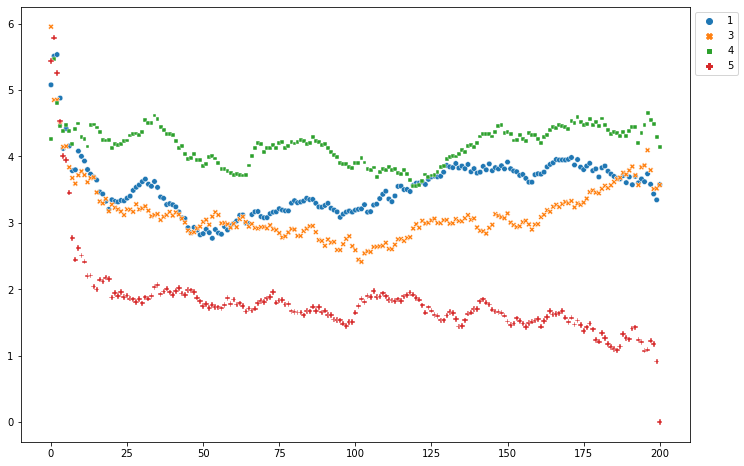

In [115]:
fig = plt.gcf()

fig.set_size_inches(12, 8)

ax = sns.scatterplot(data=plot_data, s=30)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))